In [1]:
import sys
sys.path.append('./faster_RCNN/')

from digits_dataset_class import DigitsDataset, CellsDataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import os
import numpy as np
import cv2
import torch
from torch import nn
import torch.utils.data
from PIL import Image
import pandas as pd
from scipy.io import loadmat
import pickle as pkl


from engine import train_one_epoch, evaluate
import utils
import transforms as T

import numpy as np
import random
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.datasets import load_digits

In [2]:
IMAGE_FOLDER = '../download_from_drive/data/ProcessedO7/'
ann_df = pd.read_pickle('./annotations/df_annotations.pkl')

In [3]:
def add_line(img, cols=None, rows=None):
    nlines = np.random.randint(1,5)
    for i in range(nlines):
        if np.random.random() < .5:
            x1, x2 = np.random.randint(0, img.shape[1], size=2)
            y1, y2 = np.random.randint(0, img.shape[0], size=2)
        else:
            x1, x2 = np.random.randint(-img.shape[1], 0), np.random.randint(img.shape[1], 2*img.shape[1])
            y1, y2 = np.random.randint(-img.shape[0], 2*img.shape[0], size=2)
        c = np.random.randint(10, 255)
        line_thickness = np.random.randint(1, 3)
        lineType = np.random.choice([cv2.LINE_8, cv2.LINE_AA])
        cv2.line(img, (x1, y1), (x2, y2), (c, c, c), thickness=line_thickness, lineType=lineType)
    return img


def drawline(img,pt1,pt2,color,thickness=1,style='dotted',gap=20):
    dist =((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)**.5
    pts= []
    for i in  np.arange(0,dist,gap):
        r=i/dist
        x=int((pt1[0]*(1-r)+pt2[0]*r)+.5)
        y=int((pt1[1]*(1-r)+pt2[1]*r)+.5)
        p = (x,y)
        pts.append(p)

    if style=='dotted':
        for p in pts:
            cv2.circle(img,p,thickness,color,-1)
    else:
        s=pts[0]
        e=pts[0]
        i=0
        for p in pts:
            s=e
            e=p
            if i%2==1:
                cv2.line(img,s,e,color,thickness)
            i+=1

def add_hline(img, cols=None, rows=None):
    x1, y1 = 0, np.random.randint(0, img.shape[0]-10)
    x2, y2 = img.shape[1], y1 + np.random.randint(-20, 20)
    c = np.random.randint(10, 255)
    thickness = np.random.randint(1, 5)
    style = np.random.choice(['dotted', 'default'])
    gap = np.random.randint(3, 15)
    drawline(img, (x1, y1), (x2, y2), (c, c, c), thickness, style=style, gap=gap)
    return img

def add_spots(img, cols=None, rows=None):
    nspots = np.random.randint(1,5)
    for i in range(nspots):
        x1, y1 = np.random.randint(0, img.shape[1]-20), np.random.randint(0, img.shape[0]-20)
        x2, y2 = np.random.randint(x1, x1+20), np.random.randint(y1, y1+20)
        c = np.random.randint(10, 255)
        lineType = np.random.choice([cv2.LINE_8, cv2.LINE_AA])
        cv2.rectangle(img, (x1, y1), (x2, y2), (c, c, c), thickness=-1, lineType=lineType)
    return img

def ToRGB(img, cols=None, rows=None):
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def ToGray(img, cols=None, rows=None):
     return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [4]:
transforms = A.Compose([
    A.Resize(128, 128),
    A.Rotate(limit=(0,15), p=.1),
#     A.Lambda(image=add_line, p=0.3),
#     A.Lambda(image=add_spots, p=0.3),
#     A.Lambda(image=add_hline, p=0.3),
#     A.Lambda(image=ToRGB, p=1),
#     A.RandomFog(),
#     A.Lambda(image=ToGray, p=1),
    A.CoarseDropout(p=.1),
    A.Blur(blur_limit=7, p=.2),
    A.GaussNoise(var_limit=(10.0, 100.0)),
    A.RandomBrightnessContrast(p=0.2)])

test_transforms = A.Compose([
    A.Resize(128, 128)])

In [5]:
# ann_df = ann_df[~ann_df['value'].isin(["5M","C4","v3", "6q"])]

ann_df.value = ann_df.value.apply(lambda x: ''.join([el for el in x if el.isdigit()]) if len(x)<=2 else x)

In [6]:
ann_df.shape

(8439, 3)

In [7]:
np.random.seed(314)

ids = np.random.permutation(ann_df.filename.nunique())

TRAIN_RATIO = 0.9

train_imgs = ann_df.filename.unique()[ids[:int(len(ids)*TRAIN_RATIO)]]
test_imgs = ann_df.filename.unique()[ids[int(len(ids)*TRAIN_RATIO):]]


train_df = ann_df.query('filename in @train_imgs')
test_df = ann_df.query('filename in @test_imgs')

In [8]:
test_df.to_pickle('../best_models_to_date/text_test_df.pkl')
train_df.to_pickle('../best_models_to_date/text_train_df.pkl')

In [9]:
train_dataset = CellsDataset(train_df, IMAGE_FOLDER, transforms=transforms, mode='train')
valid_dataset =  CellsDataset(test_df, IMAGE_FOLDER, transforms=test_transforms)


# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=None)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                                batch_size=8,
                                                shuffle=False,
                                                num_workers=4,
                                                collate_fn=None)

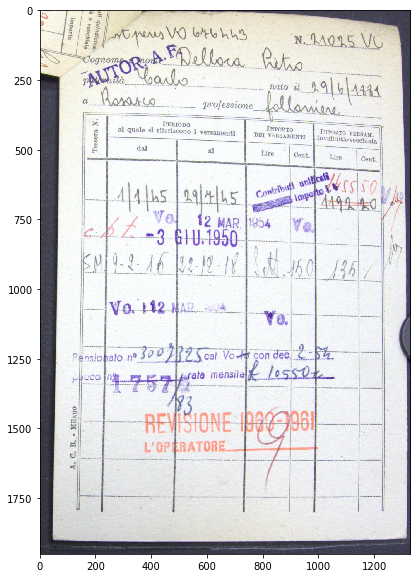

In [10]:
plt.figure(figsize=(20,10))
plt.imshow(plt.imread(os.path.join(IMAGE_FOLDER, '21025_O7_0112.jpg')))

tensor([ 1,  7, 10, 10, 10, 10]) torch.Size([3, 128, 128])


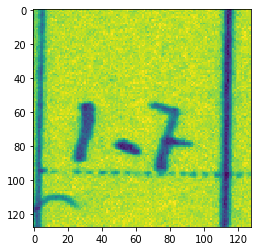

In [11]:
sample = train_dataset[130]
plt.imshow(sample[0][0].numpy())
print(sample[1], sample[0].shape)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoints_dir = 'trained_models_v1'
os.makedirs(checkpoints_dir, exist_ok=True)
device

device(type='cuda')

In [14]:
class HandDigitModel(nn.Module):
    def __init__(self):
        super(HandDigitModel, self).__init__()

        self.feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
#         print(self.feature_extractor.classifier[1])
#         self.feature_extractor.classifier[1] = nn.Conv2d(512, 512, kernel_size=(1,1), stride=(1,1))
#         self.lstm = nn.LSTM(2048, 128, num_layers=6, dropout=.1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(1000, 256), nn.ReLU(), nn.Linear(256, 11*6))

    def forward(self, x):
        x = self.feature_extractor(x)
#         x, (hh, cn) = self.lstm(x.view(len(x), 1, 2048))
#         hh = torch.transpose(hh, 0, 1)
        out = self.linear(x)
        out = out.view(len(x), 6, 11)
        return out

In [15]:
model = HandDigitModel()
model.to(device)
# model.load_state_dict(torch.load('trained_models_v0/HandDigitNet-checkpoint-v0.pt',map_location=device))
print('Model loaded!')

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.10.0


Model loaded!


In [16]:
# construct an optimizer
lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
from tqdm.notebook import tqdm

In [18]:
# preds.shape, targets.shape

In [19]:
def get_ends(vec):
    end = 0
    ids = []
    for i in range(len(vec)):
        if i % 6 == 0:
            end = 0
        if vec[i] == 10:
            if end != 1:
                ids.append(i)
            end = 1
        else:
            ids.append(i)
            end = 0
    return torch.tensor(ids, dtype=torch.long, device=device)

In [20]:
def compute_accuracy(preds, targets):
    y_pred = torch.argmax(preds,  dim=1)
    acc = torch.mean((y_pred == targets).float())
    return acc

In [23]:
EPOCHS = 30
epochs_history = []
DEVICE = device
# best_avg_err = 100.
# no_improvement = 0

for epoch in range(EPOCHS):

    model.train()
    loss_val, train_acc = 0, 0
    for batch_id, (X_batch, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        X_batch = X_batch.to(DEVICE)
        preds = model(X_batch)
        preds = preds.view(-1, 11)
        targets = targets.to(DEVICE)
        targets = targets.view(-1)
        ids = get_ends(targets)
        targets = targets[ids]
        preds = preds[ids]
        train_acc += compute_accuracy(preds, targets).item()
        loss = criterion(preds, targets)
        loss_val += loss.item()
        loss.backward()
        optimizer.step()
        del X_batch; del preds; del targets
        
    test_loss_val, test_acc = 0, 0
    optimizer.zero_grad()
    model.eval()
    for test_batch_id, (X_batch, targets) in enumerate(tqdm(valid_loader)):
        with torch.no_grad():
            optimizer.zero_grad()
            X_batch = X_batch.to(DEVICE)
            preds = model(X_batch)
            preds = preds.view(-1, 11)
            targets = targets.to(DEVICE)
            targets = targets.view(-1)
            ids = get_ends(targets)
            targets = targets[ids]
            preds = preds[ids]
            test_acc += compute_accuracy(preds, targets).item()
            loss = criterion(preds, targets)
            test_loss_val += loss.item()
        del X_batch; del preds; del targets
        

    
    epochs_history.append([loss_val/batch_id, test_loss_val/test_batch_id, train_acc/batch_id, test_acc/test_batch_id])
    test_score = test_loss_val/test_batch_id
    if test_score < best_avg_err and epoch > 0:
        torch.save(model.state_dict(), os.path.join(checkpoints_dir, 'HandDigitNet-checkpoint-v1.pt'))
        best_avg_err = test_score
        print('New checkpoint saved!')
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement == 5:
        if lr > 5e-6:
            lr *= 0.1
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print('Epoch#{} ==> Train Loss: {:.3f} Train Acc: {:.3f} | Test Loss: {:.3f} Test Acc: {:.3f}'.format(
        epoch, loss_val/batch_id, train_acc/batch_id, test_loss_val/test_batch_id, test_acc/test_batch_id))


Epoch#0 ==> Train Loss: 0.247 Train Acc: 0.925 | Test Loss: 0.386 Test Acc: 0.920



Epoch#1 ==> Train Loss: 0.237 Train Acc: 0.928 | Test Loss: 0.376 Test Acc: 0.915



New checkpoint saved!
Epoch#2 ==> Train Loss: 0.236 Train Acc: 0.927 | Test Loss: 0.331 Test Acc: 0.929



Epoch#3 ==> Train Loss: 0.222 Train Acc: 0.932 | Test Loss: 0.365 Test Acc: 0.917



Epoch#4 ==> Train Loss: 0.216 Train Acc: 0.934 | Test Loss: 0.343 Test Acc: 0.931



Epoch#5 ==> Train Loss: 0.217 Train Acc: 0.934 | Test Loss: 0.368 Test Acc: 0.928



New checkpoint saved!
Epoch#6 ==> Train Loss: 0.202 Train Acc: 0.938 | Test Loss: 0.327 Test Acc: 0.932



Epoch#7 ==> Train Loss: 0.205 Train Acc: 0.939 | Test Loss: 0.357 Test Acc: 0.921



Epoch#8 ==> Train Loss: 0.185 Train Acc: 0.945 | Test Loss: 0.353 Test Acc: 0.925



Epoch#9 ==> Train Loss: 0.192 Train Acc: 0.941 | Test Loss: 0.377 Test Acc: 0.927



Epoch#10 ==> Train Loss: 0.183 Train Acc: 0.946 | Test Loss: 0.350 Test Acc: 0.926



Epoch#11 ==> Train Loss: 0.180 Train Acc: 0.946 | Test Loss: 0.384 Test Acc: 0.920



Epoch#12 ==> Train Loss: 0.141 Train Acc: 0.959 | Test Loss: 0.341 Test Acc: 0.935



Epoch#13 ==> Train Loss: 0.119 Train Acc: 0.967 | Test Loss: 0.334 Test Acc: 0.933



Epoch#14 ==> Train Loss: 0.121 Train Acc: 0.965 | Test Loss: 0.341 Test Acc: 0.935



Epoch#15 ==> Train Loss: 0.118 Train Acc: 0.966 | Test Loss: 0.351 Test Acc: 0.933



Epoch#16 ==> Train Loss: 0.113 Train Acc: 0.967 | Test Loss: 0.343 Test Acc: 0.936



Epoch#17 ==> Train Loss: 0.114 Train Acc: 0.969 | Test Loss: 0.368 Test Acc: 0.933



Epoch#18 ==> Train Loss: 0.106 Train Acc: 0.970 | Test Loss: 0.368 Test Acc: 0.932



Epoch#19 ==> Train Loss: 0.111 Train Acc: 0.968 | Test Loss: 0.356 Test Acc: 0.938



Epoch#20 ==> Train Loss: 0.104 Train Acc: 0.972 | Test Loss: 0.359 Test Acc: 0.936



Epoch#21 ==> Train Loss: 0.106 Train Acc: 0.970 | Test Loss: 0.369 Test Acc: 0.932



Epoch#22 ==> Train Loss: 0.107 Train Acc: 0.970 | Test Loss: 0.356 Test Acc: 0.936



Epoch#23 ==> Train Loss: 0.108 Train Acc: 0.971 | Test Loss: 0.365 Test Acc: 0.936



Epoch#24 ==> Train Loss: 0.111 Train Acc: 0.969 | Test Loss: 0.350 Test Acc: 0.938



Epoch#25 ==> Train Loss: 0.107 Train Acc: 0.970 | Test Loss: 0.356 Test Acc: 0.936



Epoch#26 ==> Train Loss: 0.102 Train Acc: 0.971 | Test Loss: 0.372 Test Acc: 0.935



Epoch#27 ==> Train Loss: 0.105 Train Acc: 0.970 | Test Loss: 0.377 Test Acc: 0.935



Epoch#28 ==> Train Loss: 0.105 Train Acc: 0.971 | Test Loss: 0.373 Test Acc: 0.937



Epoch#29 ==> Train Loss: 0.098 Train Acc: 0.972 | Test Loss: 0.362 Test Acc: 0.935


In [70]:
model.load_state_dict(torch.load('trained_models_v1/HandDigitNet-checkpoint-v1.pt',map_location=device))


<All keys matched successfully>

In [103]:
test_df.reset_index().tail(15)

,index,filename,points,value
884,8056,90003_O7_0292.jpg,"(215, 1310, 418, 1436)",15-11-38
885,8057,90003_O7_0292.jpg,"(418, 1311, 621, 1436)",30-04-39
886,8058,90003_O7_0292.jpg,"(621, 1312, 721, 1437)",24
887,8059,90003_O7_0292.jpg,"(133, 1435, 214, 1561)",8
888,8060,90003_O7_0292.jpg,"(214, 1436, 418, 1562)",15-05-34
889,8061,90003_O7_0292.jpg,"(418, 1436, 622, 1563)",22-09-41
890,8062,90003_O7_0292.jpg,"(622, 1437, 721, 1564)",none
891,8063,90003_O7_0292.jpg,"(132, 1563, 213, 1699)",9
892,8064,90003_O7_0292.jpg,"(213, 1564, 417, 1699)",08-06-41
893,8065,90003_O7_0292.jpg,"(417, 1565, 623, 1700)",22-05-42


7
[ 7 10 10  7 10  3]


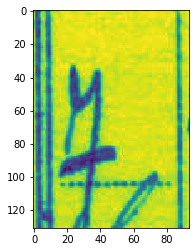

In [94]:
row = test_df.query('value!="none"').sample(1).iloc[0]
img = cv2.cvtColor(cv2.imread(os.path.join(IMAGE_FOLDER, row['filename'])), cv2.COLOR_RGB2GRAY)
x1, y1, x2, y2 = row['points']
print(row['value'])
img = img[y1:y2, x1:x2]
X_i = test_transforms(image=img)['image']
X_i = T.ToTensor()(image=X_i, target=None)[0]
X_i = torch.cat([X_i]*3, dim=0)[None]

model.eval()
with torch.no_grad():
    X_i_gpu = X_i.to(DEVICE)
    preds = model(X_i_gpu).detach().cpu().numpy()
    del X_i_gpu
print(np.argmax(preds[0], axis=1))
plt.imshow(img); plt.show()

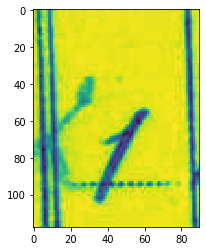

In [32]:
plt.imshow(img); plt.show()

In [210]:
row['filename']

'34113_O7_0530.jpg'

In [21]:
ann_df.query('value=="15.01.45"')

,filename,points,value
993,20057_O7_0016.jpg,"(246, 629, 499, 778)",15.01.45


In [41]:
ann_df.query('filename=="21401_O7_0322.jpg" and value!="none"').tail(50)

,filename,points,value
2154,21401_O7_0322.jpg,"(112, 636, 176, 726)",1
2155,21401_O7_0322.jpg,"(176, 638, 303, 728)",22-06-52
2156,21401_O7_0322.jpg,"(303, 640, 429, 729)",27-8-52
2157,21401_O7_0322.jpg,"(429, 643, 485, 732)",8


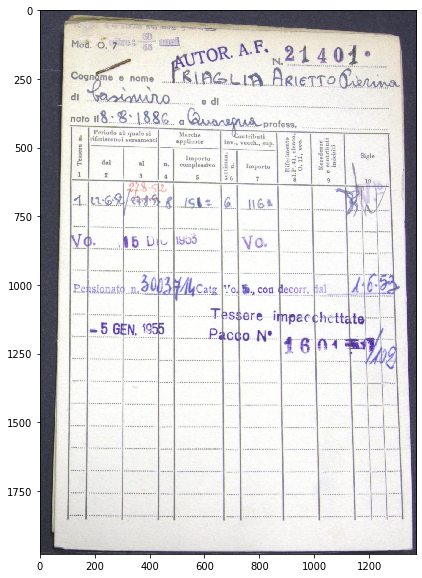

In [34]:
plt.figure(figsize=(20,10))
plt.imshow(plt.imread(os.path.join(IMAGE_FOLDER, '21401_O7_0322.jpg')))

In [ ]:
X, target = valid_dataset[0]
model.eval()
with torch.no_grad():
    X_gpu = X.to(device)[None]
    preds = model(X_gpu).detach().cpu().view(-1,11)
    preds = np.round(nn.Softmax(dim=1)(preds).numpy(),1)
    print(preds)
    print('target:' , [n if n<10 else '<end>' for n in target.numpy()])
    print('output:' , [n if n<10 else '<end>' for n in np.argmax(preds, axis=1)])
    del X_gpu
# X[0][X[0]<.5] = 0
plt.imshow(X[0]); plt.show()

In [ ]:
import cv2
%load_ext autoreload
%autoreload 2
sys.path.append('./faster_RCNN/')
from digits_dataset_class import DigitsDataset
inference_dataset =  DigitsDataset([], [],[], [],
                         transforms=test_transforms)

img_path = 'cell_test.JPG'
X = inference_dataset.preprocess(img_path)
plt.imshow(X[0]); plt.show()

In [ ]:
model.eval()
X = inference_dataset.preprocess(img_path)
with torch.no_grad():
    X_gpu = X.to(device)[None]
#     X_gpu = (X_gpu-X_gpu.min())/(X_gpu.max()-X_gpu.min())
    preds = model(X_gpu).detach().cpu().view(-1,11)
    preds = np.round(nn.Softmax(dim=1)(preds).numpy(),3)
    print(preds)
    print('output:' , [n if n<10 else '<end>' for n in np.argmax(preds, axis=1)])
    del X_gpu
plt.imshow(X[0]); plt.show()

In [ ]:
sample

In [ ]:
X, target = valid_dataset[0]
model.eval()
with torch.no_grad():
    X_gpu = X.to(device)[None]
    preds = model(X_gpu).detach().cpu().view(-1,11)
    preds = np.round(nn.Softmax(dim=1)(preds).numpy(),1)
    print(preds)
    print(np.argmax(preds, axis=1))
    print(target.numpy())
    del X_gpu
plt.imshow(X[0]); plt.show()

In [ ]:
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

# number of epochs
num_epochs = 20
#start training
for epoch in range(num_epochs):
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # update the learning rate
    lr_scheduler.step()
    
    # evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)
    
    # save model afeter the current epoch
    torch.save(model, os.path.join(checkpoints_dir, 'checkpoint_v4-' + str(epoch).zfill(2)) + '.pt')
    print()
    print()
#9.27#9.59

In [ ]:
# 370